In [1]:
import pykat
import numpy as np

import pykat.ifo.aligo as aligo
import pykat.ifo.aligo.plot
import matplotlib.pyplot as plt

import scipy
from scipy import signal

pykat.init_pykat_plotting(fmts=['svg'])

C:\Users\tvo88\Anaconda3\lib\site-packages\h5py\__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


                                              ..-
    PyKat 1.1.277         _                  '(
                          \`.|\.__...-""""-_." )
       ..+-----.._        /  ' `            .-'
   . '            `:      7/* _/._\    \   (
  (        '::;;+;;:      `-"' =" /,`"" `) /
  L.        \`:::a:f            c_/     n_'
  ..`--...___`.  .    ,
   `^-....____:   +.      www.gwoptics.org/pykat



In [83]:
### Create the baseline file

### Get the DARM Cavity Pole from the shot noise
#%run LHO.py
#base0= make_LHO()

base0 = aligo.make_kat("design_with_IMC_HAM2_FI_OMC", keepComments=True, preserveConstants=True)

base0.L0.P.value = 30

#Sometimes this setup crashes so I just keep trying
result = None
while result is None:
    try:
        base0 = aligo.setup(base0)
        base0.mod1.midx=0
        base0.mod2.midx=0
        print("Zero-ing locks")
        base0.IFO.zero_locks() #Find phases to lock the IFO
        result = 1
    except:
        pass
        print("Ran into a pykat error, trying again")
    
base_tunings = base0.IFO.get_tunings()


Pykat parsing does not preserve inline comments. Moving inline
comments before command

Zero-ing locks


In [84]:
print(base_tunings)

{'PRM': 0.001, 'ITMX': -0.001, 'ETMX': -0.00434598814528203, 'ITMY': 0.001, 'ETMY': 0.00434598814528203, 'BS': 0.0, 'SRM': -89.999, 'keys': {'phase': 2, 'maxtem': None}}


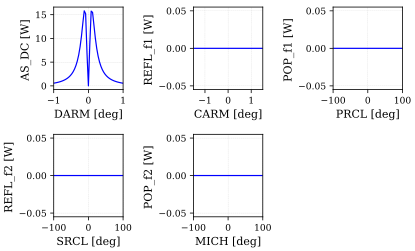

In [86]:
aligo.plot.error_signals(base0, xlimits=(-1, 1), steps=50)

In [87]:
base0.removeBlock('locks')

In [88]:
### Add some detectors
base0.parse('''

cp cavPRX x fsr
cp cavSRX x fsr

pd0 POP_DC nPOP
pd1 POP_RF90_I 90994710.0 0 nPOP
pd1 POP_RF90_Q 90994710.0 90 nPOP

pd1 POP_RF18_I 18198942.0 101 nPOP
pd1 POP_RF18_Q 18198942.0 191 nPOP

pd1 PRCL_err 90994710.0 0 nPRM2
pd1 SRCL_err 90994710.0 0 nSRM1*

%%% FTblock powers
###########################################################################
pd P_DC_AS nAS
pd PIMCtrans nREFL*
pd Px nITMX2
pd Py nITMY2
pd Pprc nPRM2
pd Psrc nSRM1*
ad prc0 0 nPRM2
ad prcf1 $f1 nPRM2
ad prcf2 $f2 nPRM2

ad asc0 0 nSRM2
ad asf1 $f1 nSRM2
ad asf2 $f2 nSRM2
ad src0 0 nSRM1*
ad srcf1 $f1 nSRM1*
ad srcf2 $f2 nSRM1*
###########################################################################
%%% FTend powers

%%% FTblock errsigs
###########################################################################

# N.B. the I signal refers to most symmetric signal, not greatest slope.
pd1 REFL_f1_I $f1 101 nREFL
pd1 REFL_f1_Q $f1 191 nREFL
pd1 REFL_f2_I $f2 14 nREFL
pd1 REFL_f2_Q $f2 104 nREFL
pd1 POP_f1_I $f1 101 nPOP
pd1 POP_f1_Q $f1 191 nPOP
pd1 POP_f2_I $f2 13 nPOP
pd1 POP_f2_Q $f2 103 nPOP
pd1 AS_f1_I $f1 0 nSRM2
pd1 AS_f1_Q $f1 90 nSRM2
pd1 AS_f2_I $f2 13 nSRM2
pd1 AS_f2_Q $f2 103 nSRM2
#pd1 OMClockpd $fdither -1.22 nAS
###########################################################################
%%% FTend errsigs
''')

In [89]:
perf_PRX = base0.deepcopy()
perf_PRX.parse('''
xaxis PRM phi lin -200 200 1001
maxtem 0
''')

out_perf_prc = perf_PRX.run()

perf_SRX = base0.deepcopy()
perf_SRX.parse('''
xaxis SRM phi lin -200 200 1001
maxtem 0
''')

out_perf_src = perf_SRX.run()

In [102]:
kat = base0.deepcopy()
kat.PR3.xbeta = 1.0e-6
#kat.PR3.Rc = kat.PR3.Rc*0.999
kat.parse('''
xaxis PRM phi lin -200 200 1001
maxtem 4
''')
out = kat.run()

In [103]:
prx_fsr = out['cavPRX_x_fsr'][0]
srx_fsr = out['cavSRX_x_fsr'][0]

In [106]:
kat1 = base0.deepcopy()
kat1.SR3.xbeta = 1.0e-6

kat1.parse('''
xaxis SRM phi lin -200 200 1001
maxtem 4
''')
out1 = kat1.run()

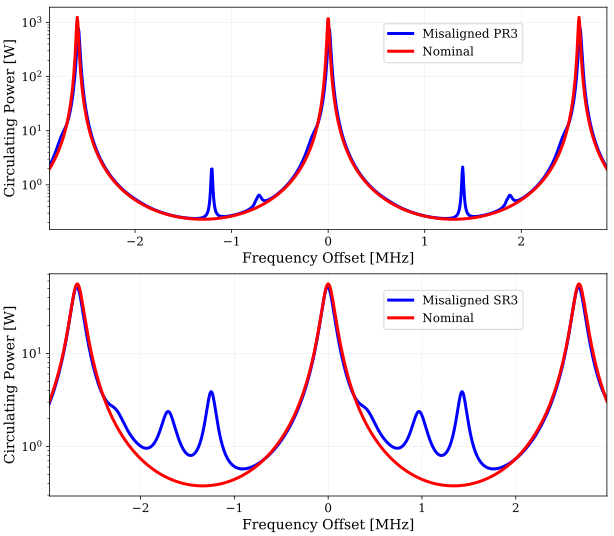

In [108]:
fig = plt.figure(figsize=(10,9),dpi=120)

ax = fig.add_subplot(211)
ax.semilogy(out.x*(prx_fsr/180)/1e6, out['Pprc'], label='Misaligned PR3', linewidth=3)
ax.semilogy(out.x*(prx_fsr/180)/1e6, out_perf_prc['Pprc'], label='Nominal',linewidth=3)
ax.set_xlabel('Frequency Offset [MHz]',fontsize=14)
ax.set_ylabel('Circulating Power [W]',fontsize=14)
plt.legend(loc=(.6, .75),fontsize=12)
plt.tick_params(labelsize=12)

ax = fig.add_subplot(212)
ax.semilogy(out.x*(srx_fsr/180)/1e6, out1['Psrc'], label='Misaligned SR3',linewidth=3)
ax.semilogy(out.x*(srx_fsr/180)/1e6, out_perf_src['Psrc'], label = 'Nominal',linewidth=3)
ax.set_xlabel('Frequency Offset [MHz]',fontsize=14)
ax.set_ylabel('Circulating Power [W]',fontsize=14)
plt.legend(loc=(.6, .75),fontsize=12)
plt.tick_params(labelsize=12)

plt.savefig('../../../Figures/PRC_SRC_ModeScan.png')